<a href="https://colab.research.google.com/github/JYSIRI/ADS1-_-ASSIGNMENT-2/blob/main/Movie_Reviews_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of IMDb Movie Reviews Using Fine-Tuned DistilBERT Models


In [1]:
import os
import random
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# Core libraries
import numpy as np
import pandas as pd
import random

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning (baseline)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# Deep learning (BERT-style model)
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification
)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Device check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# For long IMDb reviews we use a longer max sequence length
MAX_LENGTH = 256
print("Max token length:", MAX_LENGTH)

Using device: cuda
Max token length: 256


In [3]:
# Download and extract dataset (run once)
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz

def load_imdb_data(data_dir):
    texts = []
    labels = []

    for label_type in ["pos", "neg"]:
        dir_path = os.path.join(data_dir, label_type)
        for file in os.listdir(dir_path):
            with open(os.path.join(dir_path, file), encoding="utf-8") as f:
                texts.append(f.read())
                labels.append(1 if label_type == "pos" else 0)

    return pd.DataFrame({"review": texts, "label": labels})

# Load training data only (25k reviews)
df = load_imdb_data("aclImdb/train")

print("Full training set shape:", df.shape)
print("\nClass distribution:")
print(df["label"].value_counts())

# Create stratified subset
SUBSET_SIZE = 4000

df_subset, _ = train_test_split(
    df,
    train_size=SUBSET_SIZE,
    stratify=df["label"],
    random_state=42
)

print("\nSubset shape:", df_subset.shape)
print("Subset class distribution:")
print(df_subset["label"].value_counts())

df_subset.head()

--2026-01-07 10:20:50--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  41.2MB/s    in 1.9s    

2026-01-07 10:20:52 (41.2 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

Full training set shape: (25000, 2)

Class distribution:
label
1    12500
0    12500
Name: count, dtype: int64

Subset shape: (4000, 2)
Subset class distribution:
label
1    2000
0    2000
Name: count, dtype: int64


,review,label
924,I love this movie very much i watched it over ...,1
8136,This is how movies are supposed to be made: a ...,1
13611,Final Score: 1.8 (out of 10)<br /><br />After ...,0
17188,This film is the worst film I have ever seen. ...,0
24047,I really don't get how people made this film a...,0


In [4]:
# Ensure clean column names (already: review, label)
df_subset = df_subset[["review", "label"]].copy()

# Split: train (80%), temp (20%)
train_df, temp_df = train_test_split(
    df_subset,
    test_size=0.2,
    stratify=df_subset["label"],
    random_state=SEED
)

# Split temp into val (10%) and test (10%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label"],
    random_state=SEED
)

print("Train size:", train_df.shape)
print("Validation size:", val_df.shape)
print("Test size:", test_df.shape)

print("\nTrain class distribution:")
print(train_df["label"].value_counts())

print("\nValidation class distribution:")
print(val_df["label"].value_counts())

print("\nTest class distribution:")
print(test_df["label"].value_counts())

Train size: (3200, 2)
Validation size: (400, 2)
Test size: (400, 2)

Train class distribution:
label
1    1600
0    1600
Name: count, dtype: int64

Validation class distribution:
label
1    200
0    200
Name: count, dtype: int64

Test class distribution:
label
0    200
1    200
Name: count, dtype: int64


## Exploratory Data Analysis (EDA)


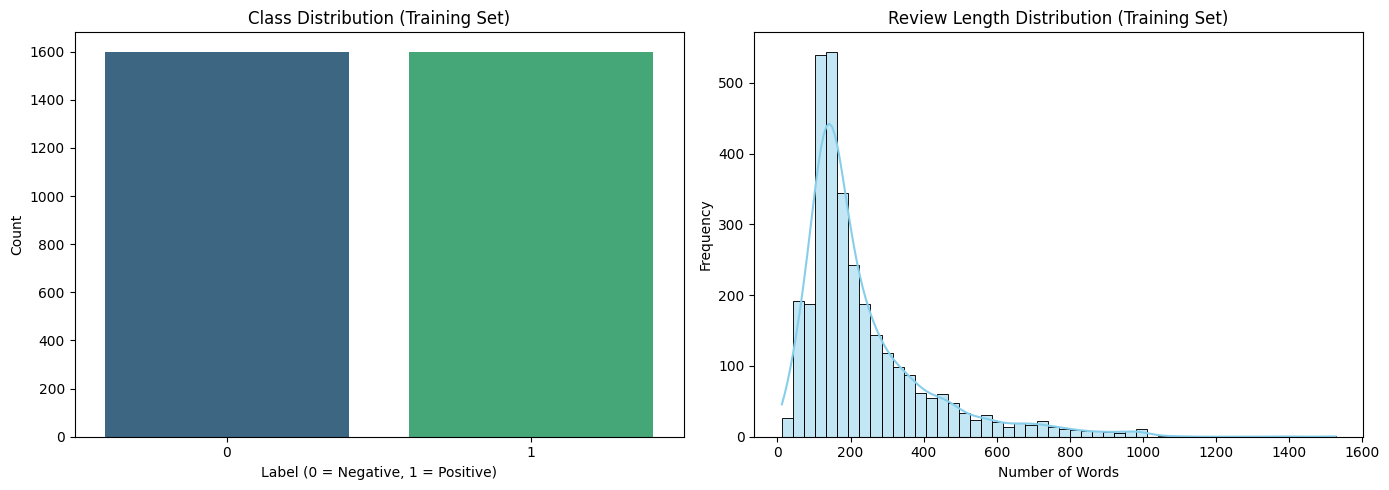

,review_length
count,3200.000000
mean,234.062187
std,175.598627
min,12.000000
25%,127.000000
50%,171.500000
75%,283.000000
max,1527.000000


In [5]:
# Add review length column (number of words)
train_df["review_length"] = train_df["review"].apply(lambda x: len(x.split()))

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Class distribution
sns.countplot(x="label", data=train_df, ax=axes[0], hue="label", palette="viridis", legend=False) # Addressed FutureWarning
axes[0].set_title("Class Distribution (Training Set)")
axes[0].set_xlabel("Label (0 = Negative, 1 = Positive)")
axes[0].set_ylabel("Count")

# Plot 2: Review length distribution
sns.histplot(train_df["review_length"], bins=50, kde=True, ax=axes[1], color="skyblue") # Changed color
axes[1].set_title("Review Length Distribution (Training Set)")
axes[1].set_xlabel("Number of Words")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Display summary statistics
train_df["review_length"].describe()

## Text Preprocessing


In [6]:
import re

def clean_review(text):
    """
    Minimal cleaning for IMDb reviews:
    - Lowercase
    - Remove HTML tags (e.g., <br />)
    - Remove extra whitespace
    """
    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)          # remove HTML tags
    text = re.sub(r"\s+", " ", text).strip()    # normalise whitespace
    return text

# Apply cleaning to all splits
train_df["clean_review"] = train_df["review"].apply(clean_review)
val_df["clean_review"] = val_df["review"].apply(clean_review)
test_df["clean_review"] = test_df["review"].apply(clean_review)

# Show before/after examples
example_rows = train_df[["review", "clean_review"]].head(3)
example_rows

,review,clean_review
9089,This is a very strange HK film in many ways. F...,this is a very strange hk film in many ways. f...
14917,"I first didn't want to watch this film, for th...","i first didn't want to watch this film, for th..."
14947,The Good: I liked this movie because it was th...,the good: i liked this movie because it was th...


## Feature and Label Preparation


In [7]:
# Features and labels for baseline model
X_train = train_df["clean_review"]
y_train = train_df["label"]

X_val = val_df["clean_review"]
y_val = val_df["label"]

X_test = test_df["clean_review"]
y_test = test_df["label"]

print("Training samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])
print("Test samples:", X_test.shape[0])

Training samples: 3200
Validation samples: 400
Test samples: 400


## Baseline Model: TF-IDF with Logistic Regression


In [8]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Logistic Regression classifier
baseline_model = LogisticRegression(
    max_iter=1000,
    random_state=SEED
)

baseline_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred_baseline = baseline_model.predict(X_test_tfidf)

# Evaluation
acc = accuracy_score(y_test, y_pred_baseline)
prec = precision_score(y_test, y_pred_baseline)
rec = recall_score(y_test, y_pred_baseline)
f1 = f1_score(y_test, y_pred_baseline)

print("Baseline Model Performance:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

# Confusion Matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
print("\nConfusion Matrix:")
print(cm_baseline)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))

Baseline Model Performance:
Accuracy : 0.8500
Precision: 0.8365
Recall   : 0.8700
F1-score : 0.8529

Confusion Matrix:
[[166  34]
 [ 26 174]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       200
           1       0.84      0.87      0.85       200

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400



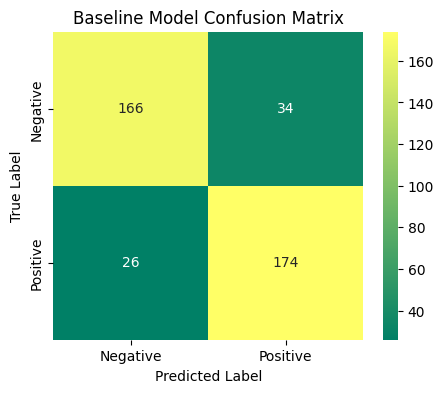

In [9]:
plt.figure(figsize=(5,4))
sns.heatmap(
    cm_baseline,
    annot=True,
    fmt="d",
    cmap="summer",
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Baseline Model Confusion Matrix")
plt.show()

## Tokenisation and Dataset Preparation for DistilBERT


In [10]:
# Load DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
)

# Quick tokenisation check
sample_text = train_df["clean_review"].iloc[0]
encoded = tokenizer(
    sample_text,
    truncation=True,
    padding="max_length",
    max_length=MAX_LENGTH,
    return_tensors="pt"
)

print("Sample text:")
print(sample_text[:300], "...\n")

print("Tokenised input_ids shape:", encoded["input_ids"].shape)
print("Attention mask shape:", encoded["attention_mask"].shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Sample text:
this is a very strange hk film in many ways. first, many of the action sequences really aren't that much fun. the very first gun battle the occurs in the film was just silly. not cool silly, or even funny silly, but just silly. that's not to say there aren't some great action scenes, but most simply ...

Tokenised input_ids shape: torch.Size([1, 256])
Attention mask shape: torch.Size([1, 256])


In [11]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [12]:
# Create datasets
train_dataset = IMDBDataset(X_train, y_train, tokenizer, MAX_LENGTH)
val_dataset = IMDBDataset(X_val, y_val, tokenizer, MAX_LENGTH)
test_dataset = IMDBDataset(X_test, y_test, tokenizer, MAX_LENGTH)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

# Sanity check
batch = next(iter(train_loader))
print("Batch input_ids shape:", batch["input_ids"].shape)
print("Batch attention_mask shape:", batch["attention_mask"].shape)
print("Batch labels shape:", batch["labels"].shape)

Batch input_ids shape: torch.Size([8, 256])
Batch attention_mask shape: torch.Size([8, 256])
Batch labels shape: torch.Size([8])


## DistilBERT Model Training

In [13]:
# Load pre-trained DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

model.to(device)

print("Model loaded and moved to device.")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and moved to device.


In [14]:
# Optimiser
optimizer = AdamW(model.parameters(), lr=2e-5)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

In [15]:
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0

    for batch in dataloader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def eval_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(dataloader), correct / total

In [16]:
EPOCHS = 5
best_val_acc = 0
best_epoch = 0

for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc = eval_epoch(model, val_loader, device)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss  : {val_loss:.4f}")
    print(f"Val Acc   : {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "best_distilbert_imdb.pt")

print("\nBest Val Acc:", best_val_acc, "at epoch", best_epoch)

Epoch 1/5
Train Loss: 0.3790
Val Loss  : 0.3245
Val Acc   : 0.8475
Epoch 2/5
Train Loss: 0.1881
Val Loss  : 0.3163
Val Acc   : 0.8575
Epoch 3/5
Train Loss: 0.0928
Val Loss  : 0.4192
Val Acc   : 0.8575
Epoch 4/5
Train Loss: 0.0481
Val Loss  : 0.5978
Val Acc   : 0.8475
Epoch 5/5
Train Loss: 0.0529
Val Loss  : 0.5875
Val Acc   : 0.8550

Best Val Acc: 0.8575 at epoch 2


In [17]:
model.load_state_dict(torch.load("best_distilbert_imdb.pt"))
model.to(device)
model.eval()
print("Loaded best model checkpoint for test evaluation.")

Loaded best model checkpoint for test evaluation.


## DistilBERT Test Evaluation


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
bert_accuracy = accuracy_score(all_labels, all_preds)
bert_precision = precision_score(all_labels, all_preds)
bert_recall = recall_score(all_labels, all_preds)
bert_f1 = f1_score(all_labels, all_preds)

print("DistilBERT Model Performance (Test Set):")
print(f"Accuracy : {bert_accuracy:.4f}")
print(f"Precision: {bert_precision:.4f}")
print(f"Recall   : {bert_recall:.4f}")
print(f"F1-score : {bert_f1:.4f}")

cm_bert = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print(cm_bert)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

DistilBERT Model Performance (Test Set):
Accuracy : 0.8475
Precision: 0.8390
Recall   : 0.8600
F1-score : 0.8494

Confusion Matrix:
[[167  33]
 [ 28 172]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.83      0.85       200
    Positive       0.84      0.86      0.85       200

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400



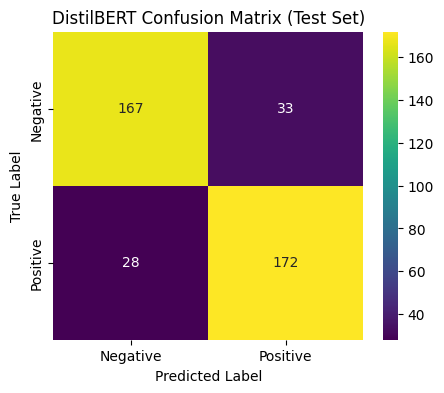

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.heatmap(
    cm_bert,
    annot=True,
    fmt="d",
    cmap="viridis", # Changed colormap to 'viridis'
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("DistilBERT Confusion Matrix (Test Set)")
plt.show()

##  Model Comparison


In [20]:
comparison_df = pd.DataFrame({
    "Model": ["TF-IDF + Logistic Regression", "DistilBERT (Fine-Tuned)"],
    "Accuracy": [acc, bert_accuracy],
    "Precision": [prec, bert_precision],
    "Recall": [rec, bert_recall],
    "F1-score": [f1, bert_f1]
})

comparison_df

,Model,Accuracy,Precision,Recall,F1-score
0,TF-IDF + Logistic Regression,0.8500,0.836538,0.87,0.852941
1,DistilBERT (Fine-Tuned),0.8475,0.839024,0.86,0.849383


## Sample Predictions


In [21]:
def predict_sentiment(text, model, tokenizer, device):
    model.eval()

    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )

    with torch.no_grad():
        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)
        pred = torch.argmax(probs, dim=1).item()

    label = "Positive" if pred == 1 else "Negative"
    confidence = probs[0][pred].item()

    return label, confidence

In [22]:
sample_reviews = [
    "This movie was absolutely fantastic. The performances were brilliant and the story was engaging throughout.",
    "The film was boring and far too long. I almost fell asleep halfway through.",
    "It had some good moments, but overall the movie failed to impress me."
]

for review in sample_reviews:
    label, confidence = predict_sentiment(review, model, tokenizer, device)
    print(f"Review: {review}")
    print(f"Prediction: {label} (confidence: {confidence:.2f})\n")

Review: This movie was absolutely fantastic. The performances were brilliant and the story was engaging throughout.
Prediction: Positive (confidence: 0.99)

Review: The film was boring and far too long. I almost fell asleep halfway through.
Prediction: Negative (confidence: 0.95)

Review: It had some good moments, but overall the movie failed to impress me.
Prediction: Negative (confidence: 0.99)

